In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import GetTrainDF, GetTestDF

In [165]:
df_train = GetTrainDF()
df_test = GetTestDF()

df_train.shape, df_test.shape

((14838, 34), (9893, 32))

In [173]:
numeric_cols = df_train.drop(columns=["EC1", "EC2", "fr_COO", "fr_COO2", "id"], axis=1).columns.tolist()
cat_cols = df_train.select_dtypes(include="category").columns.tolist()
target_cols = "EC1", "EC2"

In [174]:
for col in numeric_cols:
    print("Column\tType\tMin\tMax\tUniqueVals")
    print(f"{col}\t{df_train[col].dtype}\t{df_train[col].min()}\t{df_train[col].max()}\t{df_train[col].unique().size}\n")

Column	Type	Min	Max	UniqueVals
BertzCT	float64	0.0	4069.95978	2368

Column	Type	Min	Max	UniqueVals
Chi1	float64	0.0	69.55116728	1259

Column	Type	Min	Max	UniqueVals
Chi1n	float64	0.0	50.17458776	3157

Column	Type	Min	Max	UniqueVals
Chi1v	float64	0.0	53.43195375	3306

Column	Type	Min	Max	UniqueVals
Chi2n	float64	0.0	32.19536806	3634

Column	Type	Min	Max	UniqueVals
Chi2v	float64	0.0	34.57931288	3725

Column	Type	Min	Max	UniqueVals
Chi3v	float64	0.0	22.88083629	3448

Column	Type	Min	Max	UniqueVals
Chi4n	float64	0.0	16.0728097	2930

Column	Type	Min	Max	UniqueVals
EState_VSA1	float64	0.0	363.7059541	719

Column	Type	Min	Max	UniqueVals
EState_VSA2	float64	0.0	99.936429	445

Column	Type	Min	Max	UniqueVals
ExactMolWt	float64	1.007276452	2237.31849	1666

Column	Type	Min	Max	UniqueVals
FpDensityMorgan1	float64	-666.0	3.0	556

Column	Type	Min	Max	UniqueVals
FpDensityMorgan2	float64	-666.0	3.2	650

Column	Type	Min	Max	UniqueVals
FpDensityMorgan3	float64	-666.0	3.4	654

Column	Type	Min	Max	UniqueVa

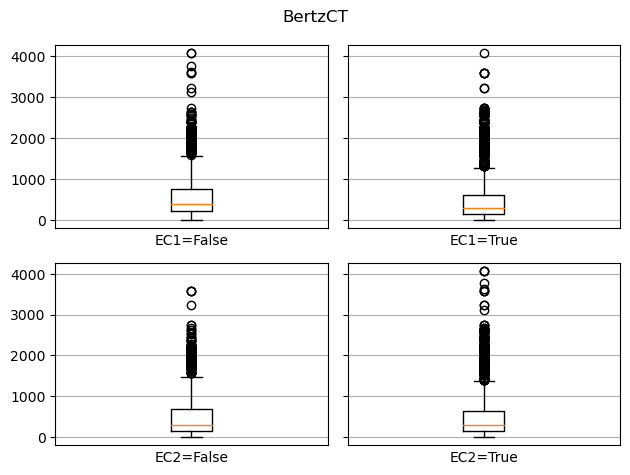

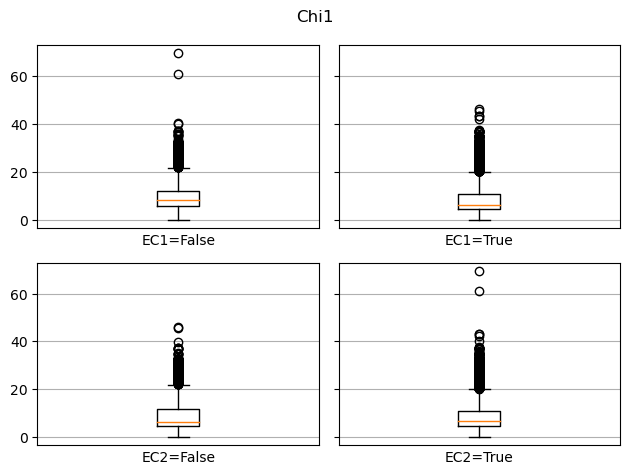

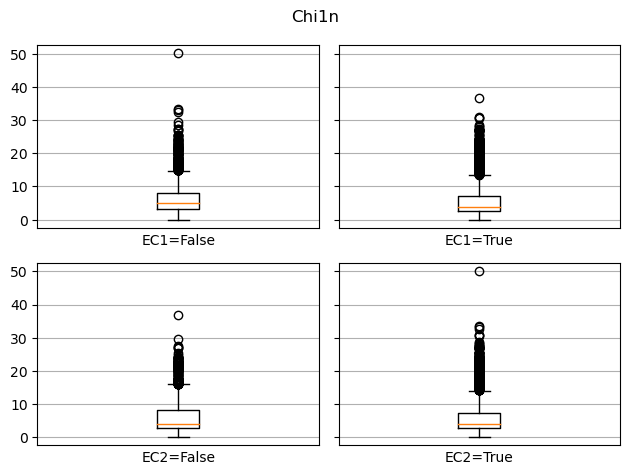

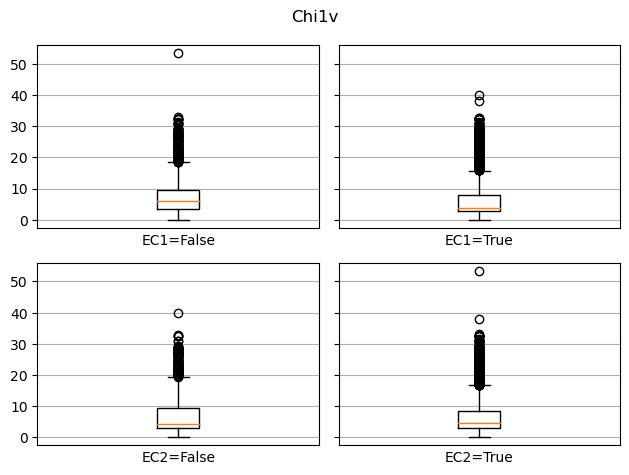

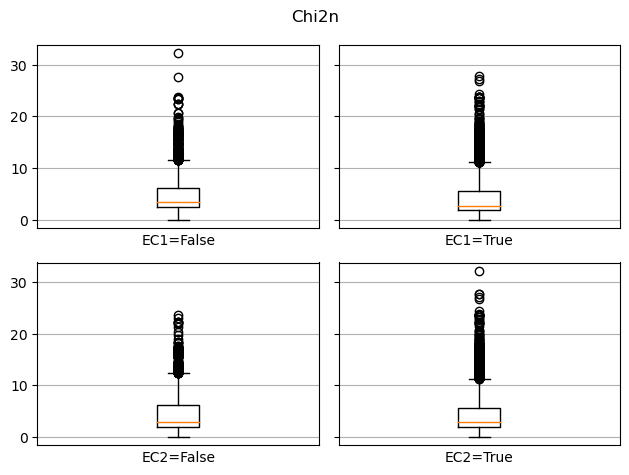

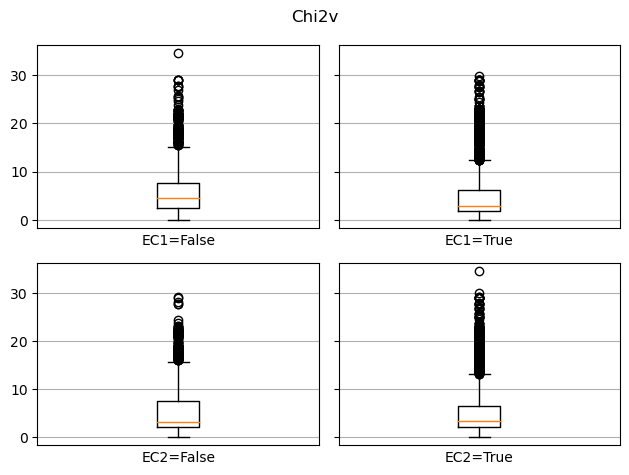

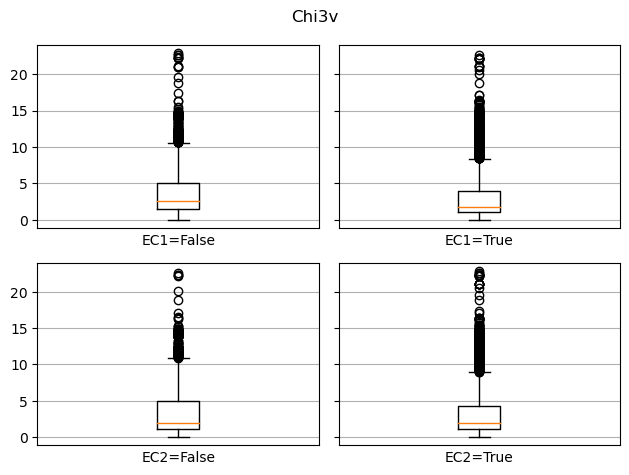

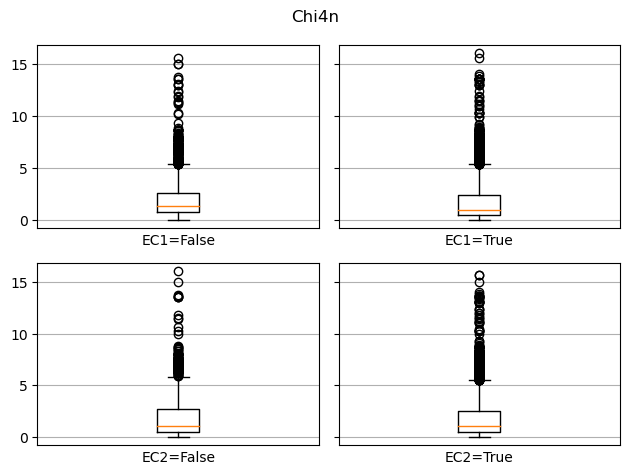

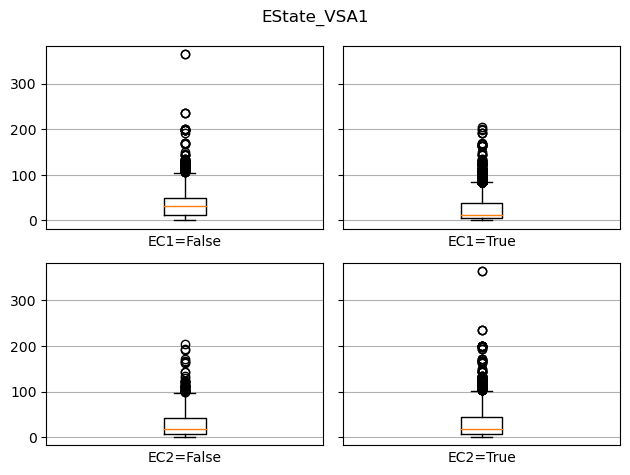

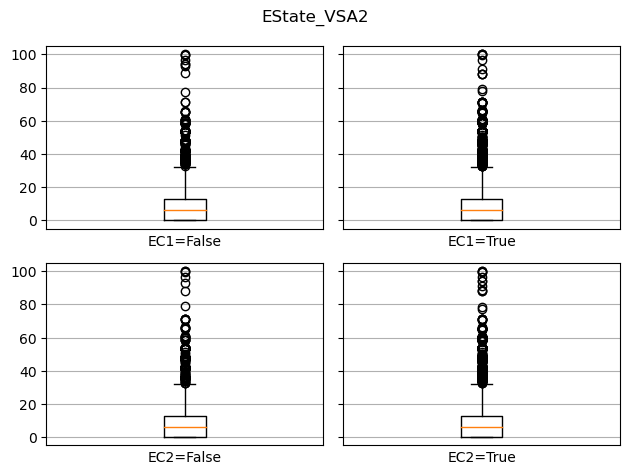

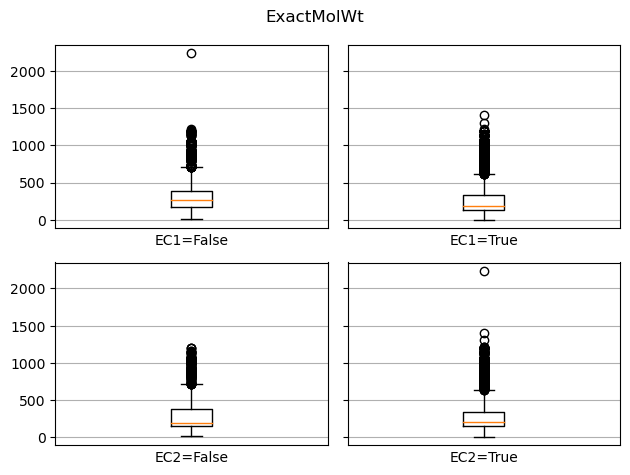

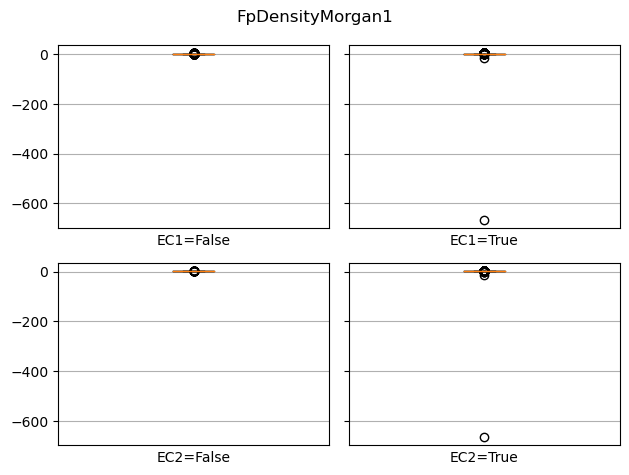

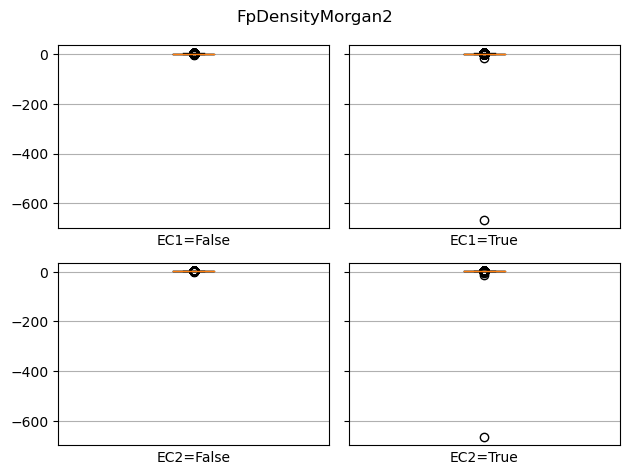

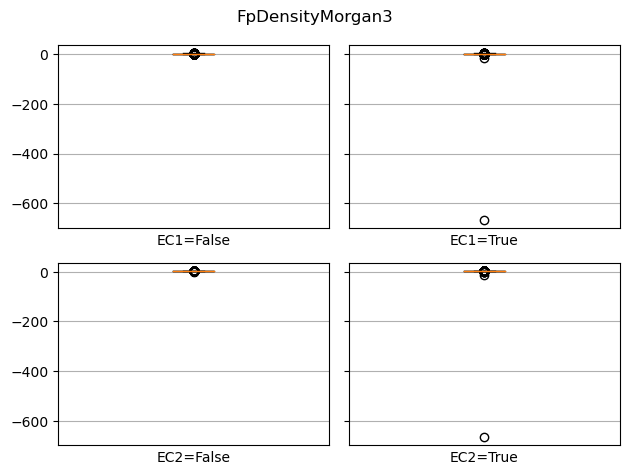

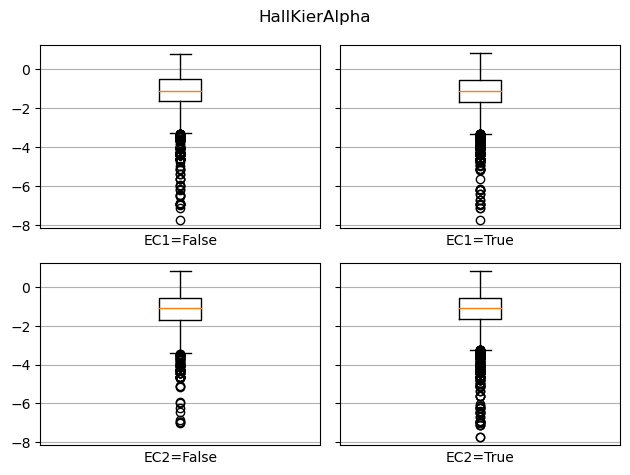

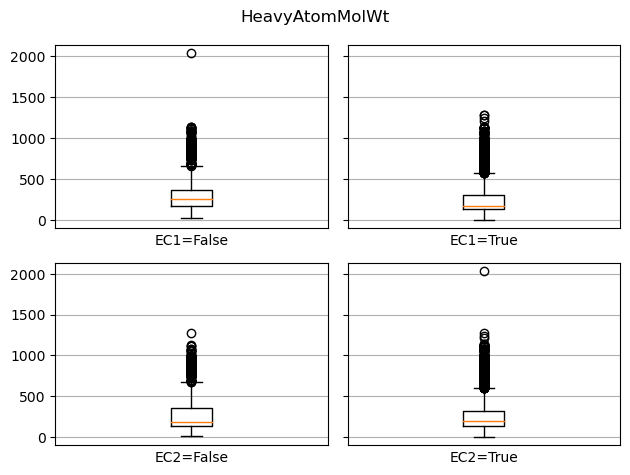

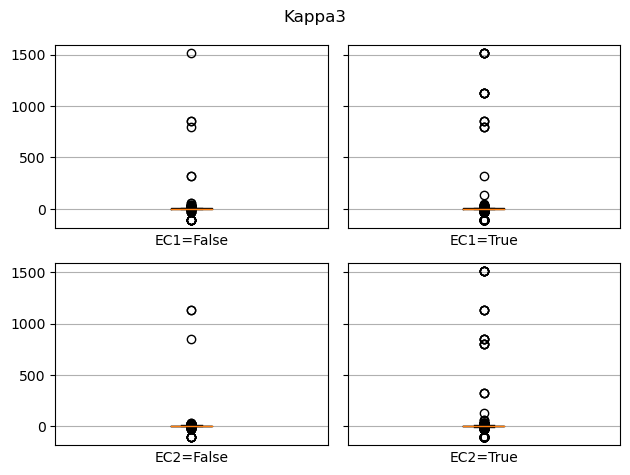

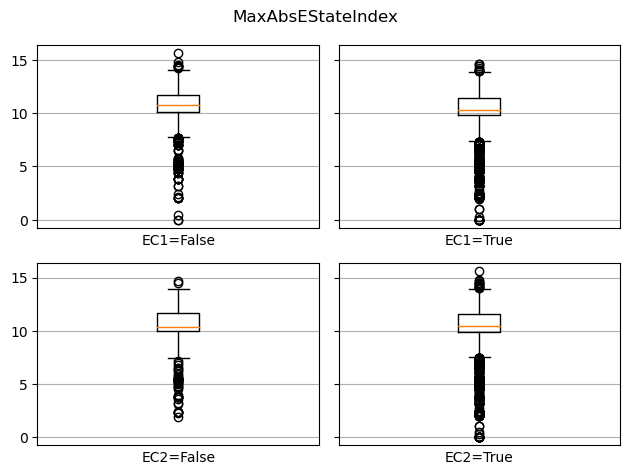

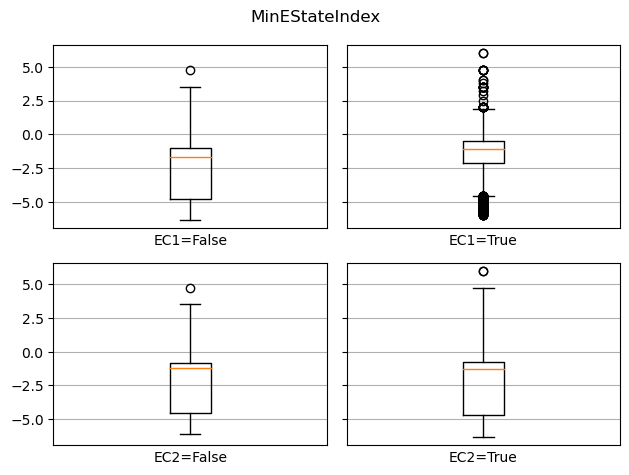

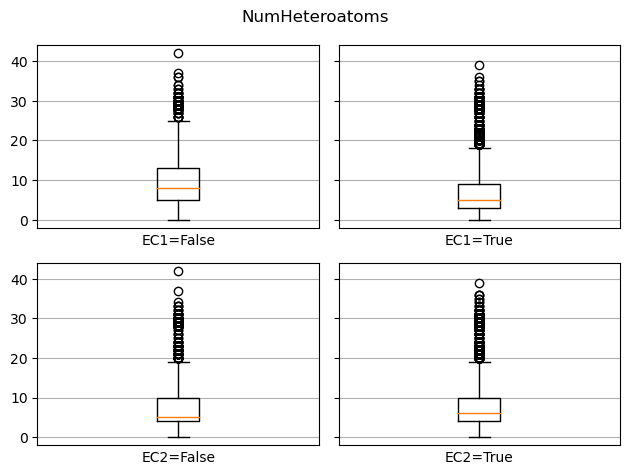

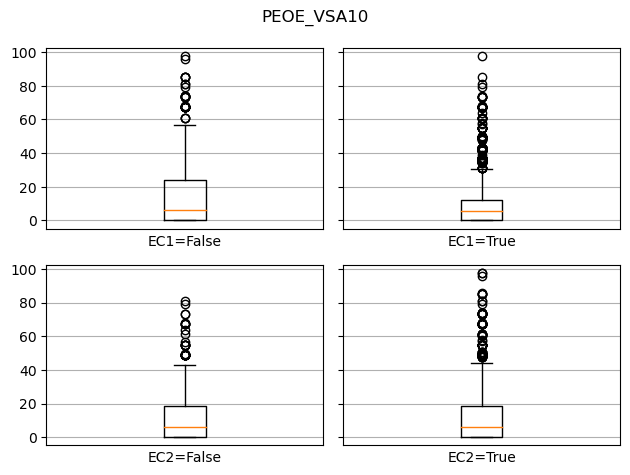

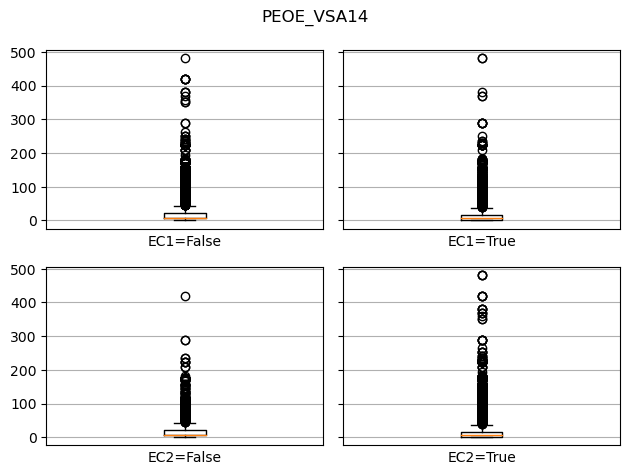

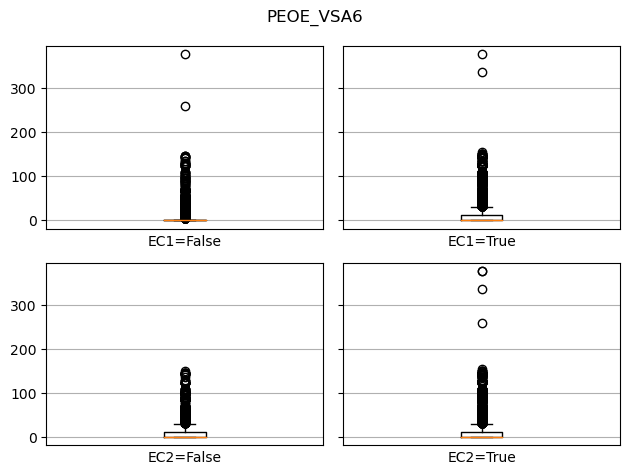

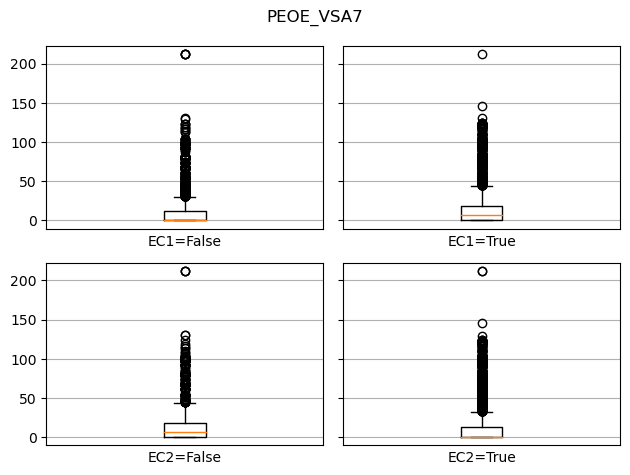

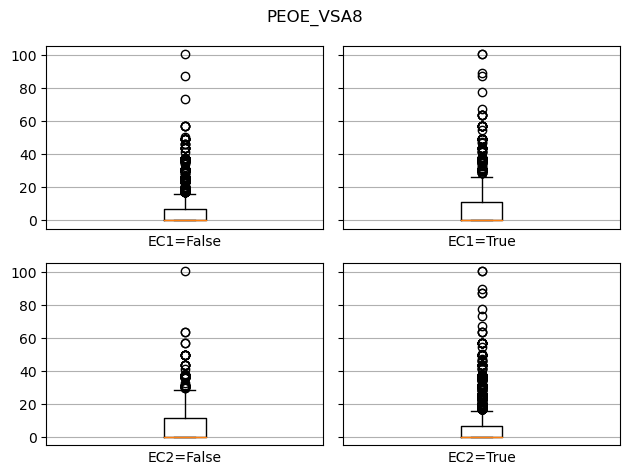

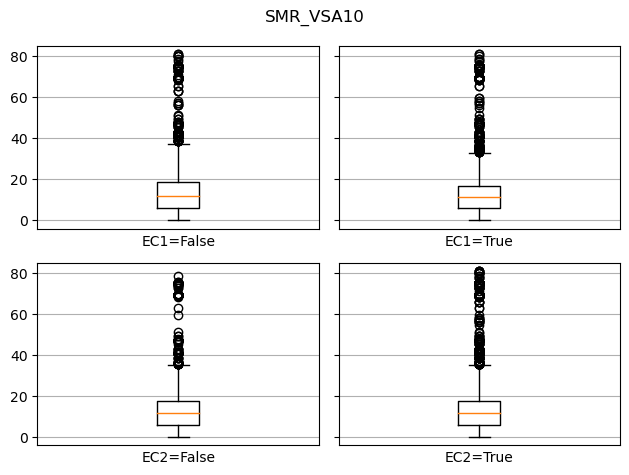

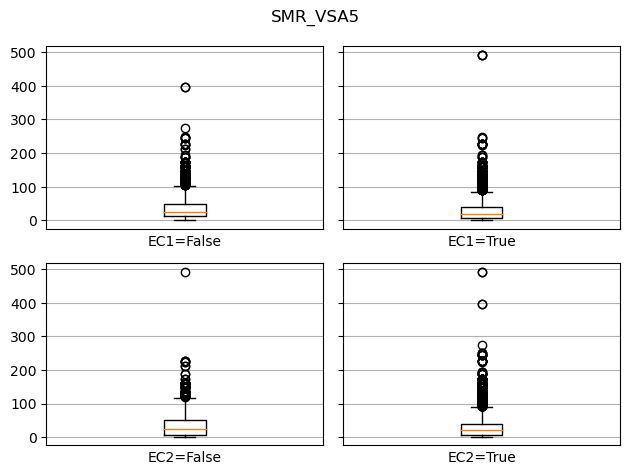

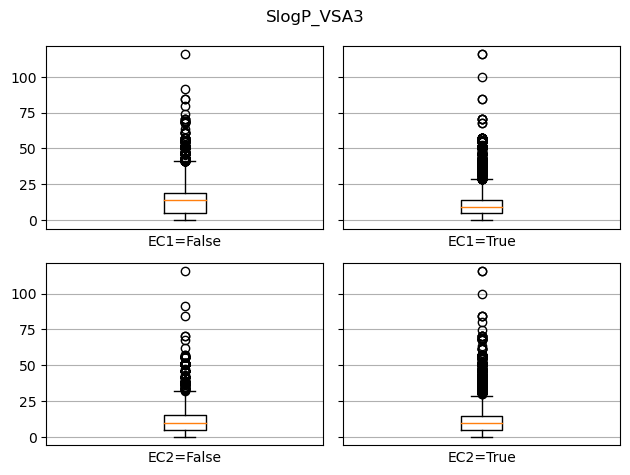

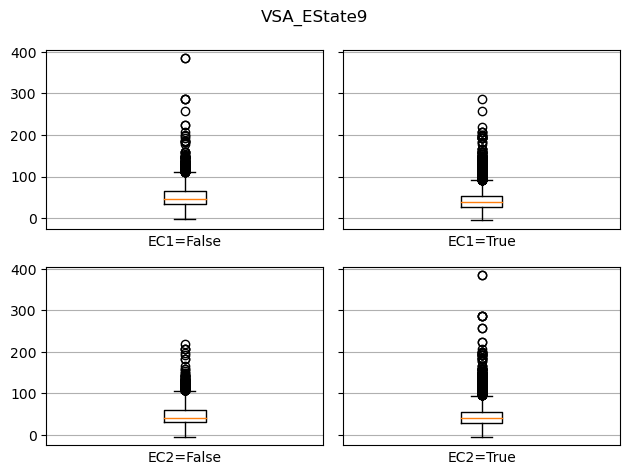

In [175]:
for numeric_col in numeric_cols:

  fig, (axup, axbot) = plt.subplots(ncols=2, nrows=2, sharey=True)
  fig.suptitle(f'{numeric_col}')

  for target_col, axO in zip(target_cols, (axup, axbot)): 

    for (name, group), (ax) in zip(df_train.groupby(target_col), axO):
      ax.boxplot(group[numeric_col].values)
      ax.set_xlabel(f'{target_col}={name}')
      ax.set_xticks([])
      ax.grid()

  plt.tight_layout()
  plt.show()

In [7]:
# total number of missing values
print(f"Total number of rows with missing values in training set: {df_train.isna().sum().sum()}")
print(f"Total number of rows with missing values in test set: {df_test.isna().sum().sum()}")

Total number of rows with missing values in training set: 0
Total number of rows with missing values in test set: 0


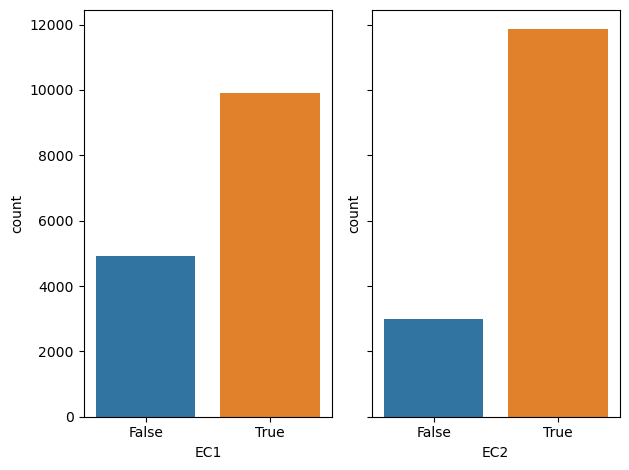

In [8]:
# use seaborn to plot the distribution of EC1 and EC2 in the training set

import seaborn as sns

fig, (axup, axbot) = plt.subplots(ncols=2, nrows=1, sharey=True)

sns.countplot(x="EC1", data=df_train, ax=axup)
sns.countplot(x="EC2", data=df_train, ax=axbot)

plt.tight_layout()

plt.show()

In [179]:
# prepare the cat_cols for the model
try:
  df_train = pd.get_dummies(df_train, columns=cat_cols, drop_first=True)
except:
  pass

df_train.shape

(14838, 46)

In [180]:
# prepare a training set and a validation set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df_train.drop(columns=["EC1", "EC2"], axis=1),
    df_train[["EC1", "EC2"]],
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df_train[["EC1", "EC2"]],
)


In [182]:
# perform a grid search to find the best hyperparameters for the random forest classifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [100, 110],
    "max_depth": [None, 4, 5, 6],
    "min_samples_split": [1, 2, 3],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring="roc_auc_ovr",
    n_jobs=-1,
    cv=5,
    verbose=1,
)

grid_search.fit(X_train, y_train)

winner_params = grid_search.best_params_.copy()

winner_params

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/Users/rmn/miniconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmn/miniconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rmn/miniconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/Users/rmn/miniconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 327, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rmn/miniconda3/envs/DataScience/lib/python3.11/site-

InvalidParameterError: The 'min_samples_split' parameter of RandomForestClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.

In [181]:
# fit a random forest classifier to the training set that predicts EC1 and EC2
from sklearn.ensemble import RandomForestClassifier

winner_params = {
  'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 100
}

rfc = RandomForestClassifier(
    **winner_params
)

rfc.fit(X_train, y_train)

# evaluate the model on the validation set
from sklearn.metrics import classification_report

y_pred = rfc.predict(X_val)
y_pred_proba = rfc.predict_proba(X_val)
print(classification_report(y_val, y_pred, target_names=["EC1", "EC2"]))


              precision    recall  f1-score   support

         EC1       0.73      0.88      0.80      1982
         EC2       0.80      1.00      0.89      2372

   micro avg       0.77      0.94      0.85      4354
   macro avg       0.76      0.94      0.84      4354
weighted avg       0.77      0.94      0.85      4354
 samples avg       0.77      0.91      0.81      4354



/Users/rmn/miniconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Grid Search Result

```{python3}
winner_params = {
  'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 100
}
```

In [13]:
CASE = 45

print(f"Prediction for case {CASE}: {y_pred[CASE]}")

print(f"Prediction probabilities for case {CASE} Var1: {y_pred_proba[0][CASE]}")
print(f"Prediction probabilities for case {CASE} Var2: {y_pred_proba[1][CASE]}")

Prediction for case 45: [ True  True]
Prediction probabilities for case 45 Var1: [0.18883442 0.81116558]
Prediction probabilities for case 45 Var2: [0.19833348 0.80166652]


In [14]:
# lets try to build a pipeline that reduces the number of features
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("selector", RFE(rfc, n_features_to_select=20)),
        ("rfc", RandomForestClassifier(**winner_params)),
    ]
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)

print(classification_report(y_val, y_pred, target_names=["EC1", "EC2"]))



              precision    recall  f1-score   support

         EC1       0.73      0.87      0.79      1982
         EC2       0.80      1.00      0.89      2372

   micro avg       0.77      0.94      0.85      4354
   macro avg       0.76      0.94      0.84      4354
weighted avg       0.77      0.94      0.85      4354
 samples avg       0.77      0.91      0.81      4354



/Users/roman/miniconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# lets build a preprocessing pipeline

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("selector", RFE(RandomForestClassifier(), n_features_to_select=20)),
    ]
)

pipeline.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=20))])

In [16]:
X_train_pp = pipeline.transform(X_train)
y_train_pp = y_train

In [17]:
# lets try a xga boost classifier

from xgboost import XGBClassifier